In [ ]:
!pip install opencv-python-headless

In [ ]:
import os
import cv2
import numpy as np
from PIL import Image

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report, f1_score, confusion_matrix, roc_curve, auc

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms

import kagglehub
import pandas as pd
import itertools

torch.backends.cudnn.benchmark = True


In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device


'cuda'

In [ ]:
import kagglehub

# Download latest version of dataset
path = kagglehub.dataset_download("murtozalikhon/brain-tumor-multimodal-image-ct-and-mri")

print("Dataset path:", path)

# MRI ROOT PATH
mri_root = os.path.join(path, "Dataset", "Brain Tumor MRI images")

print("MRI root:", mri_root)


Using Colab cache for faster access to the 'brain-tumor-multimodal-image-ct-and-mri' dataset.
Dataset path: /kaggle/input/brain-tumor-multimodal-image-ct-and-mri
MRI root: /kaggle/input/brain-tumor-multimodal-image-ct-and-mri/Dataset/Brain Tumor MRI images


MRI does not need CLAHE or sharpening (based on the data exploration), so we apply only intensity standardization

In [ ]:
IMAGE_SIZE = 224

def preprocess_mri_image(path):
    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, (IMAGE_SIZE, IMAGE_SIZE), interpolation=cv2.INTER_AREA)

    # Normalize: (x - μ) / σ
    img = img.astype(np.float32)
    img = (img - img.mean()) / (img.std() + 1e-6)

    # Convert grayscale → 3-channel
    img = np.stack([img, img, img], axis=-1)

    return img


In [ ]:
cached_images = []
cached_labels = []

for label_name in ["Tumor", "Healthy"]:
    folder = os.path.join(mri_root, label_name)
    label = 1 if label_name == "Tumor" else 0

    for f in os.listdir(folder):
        if f.lower().endswith(("jpg", "jpeg", "png")):
            img = preprocess_mri_image(os.path.join(folder, f))
            cached_images.append(img)
            cached_labels.append(label)

cached_images = np.array(cached_images)
cached_labels = np.array(cached_labels)

print("Total MRI Samples:", len(cached_labels))


Total MRI Samples: 5000


In [ ]:
class CachedMRIDataset(Dataset):
    def __init__(self, indices, train=True):
        self.indices = indices
        self.train = train
        self.aug = transforms.Compose([
            transforms.RandomRotation(10),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor()
        ])
        self.noaug = transforms.ToTensor()

    def __len__(self):
        return len(self.indices)

    def __getitem__(self, i):
        idx = self.indices[i]
        img = cached_images[idx]
        label = cached_labels[idx]

        img = (255*(img - img.min())/(img.max() - img.min())).astype("uint8")
        img = Image.fromarray(img)

        img = self.aug(img) if self.train else self.noaug(img)
        return img, label


In [ ]:
def build_model():
    model = models.resnet18(weights="IMAGENET1K_V1")
    model.fc = nn.Linear(model.fc.in_features, 2)
    model = model.to(device)

    if torch.__version__.startswith("2"):
        model = torch.compile(model)

    return model

In [ ]:
train_transform = transforms.Compose([
    transforms.RandomRotation(10),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor()
])

val_transform = transforms.Compose([
    transforms.ToTensor()
])

In [ ]:
criterion = nn.CrossEntropyLoss()
scaler = torch.amp.GradScaler("cuda")

In [ ]:
#Holds the different optimizations we could do.
param_grid = {
    "lr": [1e-4, 3e-4, 1e-5],
    "batch_size": [16, 32],
    "optimizer": ["adam", "sgd"],
    "weight_decay": [0, 1e-4]
}

In [ ]:
def make_optimizer(model, name, lr, wd):
    if name == "adam":
        return optim.Adam(model.parameters(), lr=lr, weight_decay=wd)
    return optim.SGD(model.parameters(), lr=lr, momentum=0.9, weight_decay=wd)

In [ ]:
def train_one_epoch(model, optimizer, loader):
    model.train()
    total, correct = 0, 0
    running_loss = 0

    for imgs, labels in loader:
        imgs, labels = imgs.to(device), labels.to(device)
        optimizer.zero_grad()

        with torch.amp.autocast("cuda"):
            outputs = model(imgs)
            loss = criterion(outputs, labels)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        running_loss += loss.item()
        preds = outputs.argmax(1)
        correct += (preds == labels).sum().item()
        total += len(labels)

    return running_loss/len(loader), correct/total

In [ ]:
def eval_epoch(model, loader):
    model.eval()
    preds_all, labels_all = [], []
    correct, total = 0, 0

    with torch.no_grad():
        for imgs, labels in loader:
            imgs, labels = imgs.to(device), labels.to(device)

            with torch.amp.autocast("cuda"):
                outputs = model(imgs)

            preds = outputs.argmax(1)
            preds_all.extend(preds.cpu().numpy())
            labels_all.extend(labels.cpu().numpy())

            correct += (preds == labels).sum().item()
            total += len(labels)

    return correct / total, preds_all, labels_all


In [ ]:
def evaluate_config(lr, bs, opt_name, wd):
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    fold_accs, fold_f1s = [], []

    for fold, (train_idx, val_idx) in enumerate(
        skf.split(np.zeros(len(cached_labels)), cached_labels), 1
    ):
        train_loader = DataLoader(CachedMRIDataset(train_idx, train=True), batch_size=bs, shuffle=True, num_workers=2)
        val_loader   = DataLoader(CachedMRIDataset(val_idx, train=False), batch_size=bs, shuffle=False, num_workers=2)

        model = build_model()
        optimizer = make_optimizer(model, opt_name, lr, wd)

        for epoch in range(2):
            train_one_epoch(model, optimizer, train_loader)

        acc, preds_all, labels_all = eval_epoch(model, val_loader)
        f1 = f1_score(labels_all, preds_all, average="binary")

        fold_accs.append(acc)
        fold_f1s.append(f1)

        print(f"Fold {fold}: Acc={acc:.4f}  F1={f1:.4f}")

    return np.mean(fold_accs), np.mean(fold_f1s)

In [ ]:
results = []
keys, values = zip(*param_grid.items())
configs = [dict(zip(keys, v)) for v in itertools.product(*values)]

for cfg in configs:
    print("\nTesting:", cfg)

    mean_acc, mean_f1 = evaluate_config(
        lr=cfg["lr"],
        bs=cfg["batch_size"],
        opt_name=cfg["optimizer"],
        wd=cfg["weight_decay"]
    )

    results.append({
        **cfg,
        "mean_accuracy": mean_acc,
        "mean_f1": mean_f1
    })

df_results = pd.DataFrame(results).sort_values("mean_f1", ascending=False)
df_results


Testing: {'lr': 0.0001, 'batch_size': 16, 'optimizer': 'adam', 'weight_decay': 0}
Fold 1: Acc=0.9940  F1=0.9950
Fold 2: Acc=0.9920  F1=0.9933
Fold 3: Acc=0.9920  F1=0.9933
Fold 4: Acc=0.9910  F1=0.9925
Fold 5: Acc=0.9960  F1=0.9967

Testing: {'lr': 0.0001, 'batch_size': 16, 'optimizer': 'adam', 'weight_decay': 0.0001}
Fold 1: Acc=0.9960  F1=0.9967
Fold 2: Acc=0.9930  F1=0.9942
Fold 3: Acc=0.9850  F1=0.9876
Fold 4: Acc=0.9940  F1=0.9950
Fold 5: Acc=0.9950  F1=0.9958

Testing: {'lr': 0.0001, 'batch_size': 16, 'optimizer': 'sgd', 'weight_decay': 0}
Fold 1: Acc=0.9590  F1=0.9657
Fold 2: Acc=0.9660  F1=0.9717
Fold 3: Acc=0.9490  F1=0.9567
Fold 4: Acc=0.9650  F1=0.9711
Fold 5: Acc=0.9670  F1=0.9722

Testing: {'lr': 0.0001, 'batch_size': 16, 'optimizer': 'sgd', 'weight_decay': 0.0001}
Fold 1: Acc=0.9570  F1=0.9646
Fold 2: Acc=0.9630  F1=0.9692
Fold 3: Acc=0.9540  F1=0.9617
Fold 4: Acc=0.9660  F1=0.9717
Fold 5: Acc=0.9630  F1=0.9687

Testing: {'lr': 0.0001, 'batch_size': 32, 'optimizer': 'ada

,lr,batch_size,optimizer,weight_decay,mean_accuracy,mean_f1
5,0.00010,32,adam,0.0001,0.9942,0.995158
0,0.00010,16,adam,0.0000,0.9930,0.994141
1,0.00010,16,adam,0.0001,0.9926,0.993843
4,0.00010,32,adam,0.0000,0.9924,0.993605
16,0.00001,16,adam,0.0000,0.9896,0.991299
13,0.00030,32,adam,0.0001,0.9892,0.990843
9,0.00030,16,adam,0.0001,0.9874,0.989292
17,0.00001,16,adam,0.0001,0.9866,0.988807
11,0.00030,16,sgd,0.0001,0.9864,0.988692
8,0.00030,16,adam,0.0000,0.9858,0.988072


In [ ]:
sns.set_theme(style="whitegrid", context="talk")


/tmp/ipython-input-1970984016.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=df_results.index, y=df_results["mean_accuracy"], palette="Blues_d")


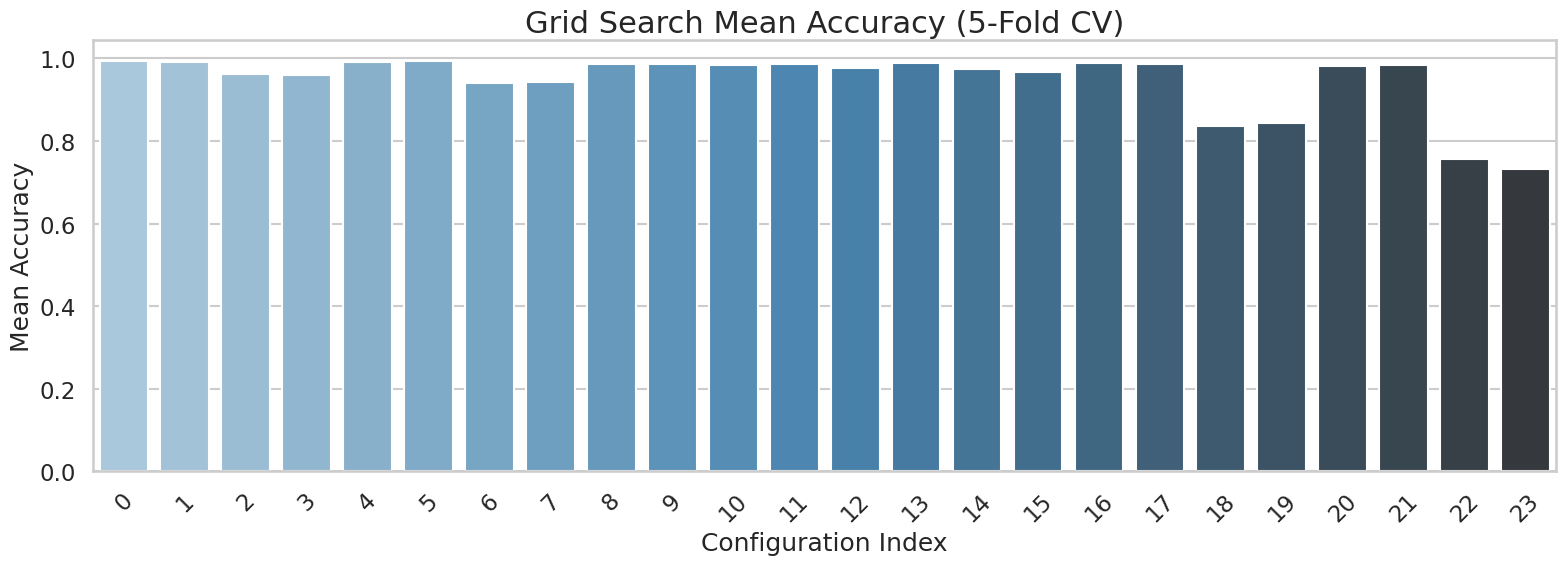

In [ ]:
plt.figure(figsize=(16,6))
sns.barplot(x=df_results.index, y=df_results["mean_accuracy"], palette="Blues_d")

plt.title("Grid Search Mean Accuracy (5-Fold CV)", fontsize=22)
plt.ylabel("Mean Accuracy", fontsize=18)
plt.xlabel("Configuration Index", fontsize=18)
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()


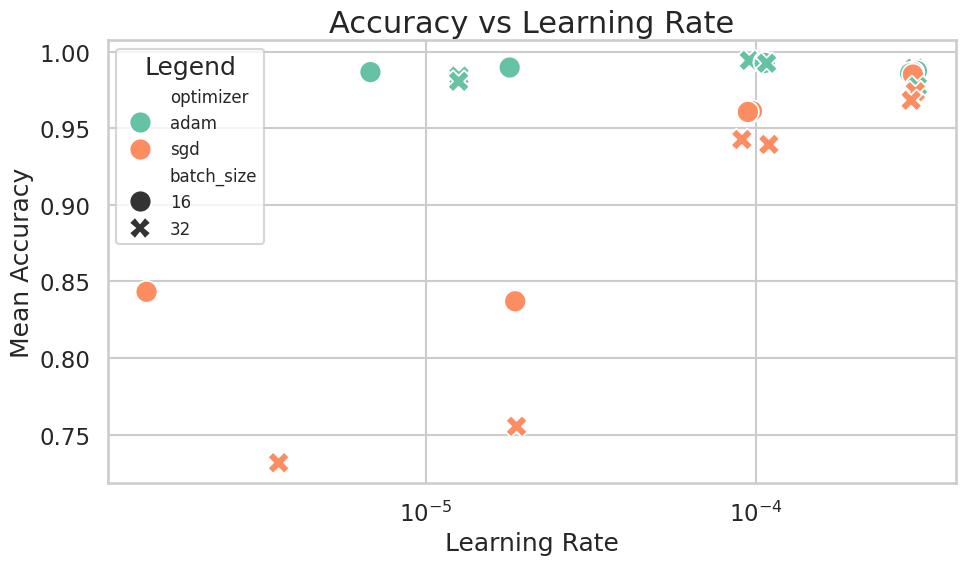

In [ ]:
plt.figure(figsize=(10,6))

# Add jitter to avoid overlapping points
def jitter(values, amount=0.00001):
    return values + np.random.uniform(-amount, amount, len(values))

sns.scatterplot(
    data=df_results,
    x=jitter(df_results["lr"]),
    y="mean_accuracy",
    hue="optimizer",
    style="batch_size",
    s=250,
    palette="Set2",
)

plt.xscale("log")
plt.xlabel("Learning Rate", fontsize=18)
plt.ylabel("Mean Accuracy", fontsize=18)
plt.title("Accuracy vs Learning Rate", fontsize=22)

plt.legend(title="Legend", fontsize=12)
plt.tight_layout()
plt.show()


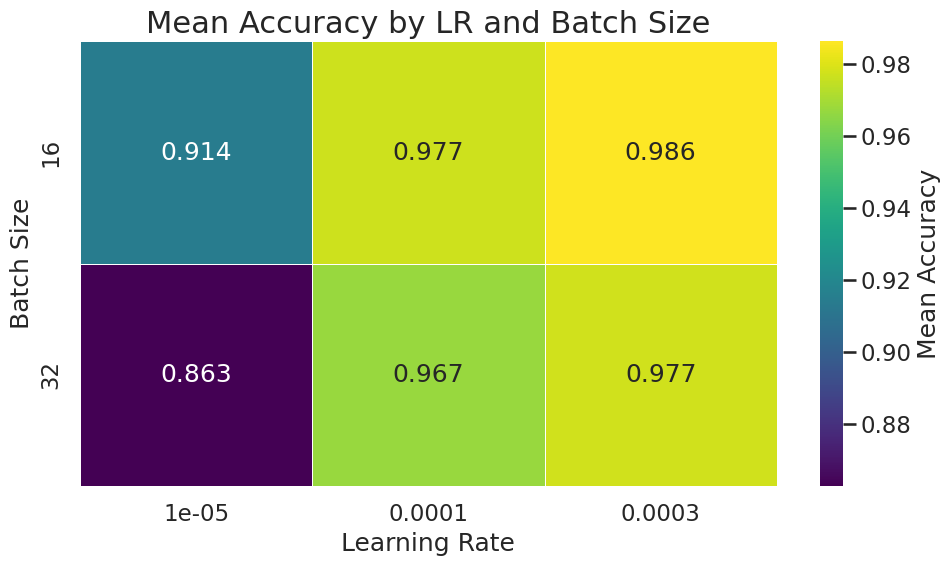

In [ ]:
heatmap_df = df_results.pivot_table(
    index="batch_size",
    columns="lr",
    values="mean_accuracy"
).sort_index()

plt.figure(figsize=(10,6))
sns.heatmap(
    heatmap_df,
    annot=True,
    cmap="viridis",
    fmt=".3f",
    linewidths=.5,
    cbar_kws={"label": "Mean Accuracy"}
)

plt.title("Mean Accuracy by LR and Batch Size", fontsize=22)
plt.xlabel("Learning Rate", fontsize=18)
plt.ylabel("Batch Size", fontsize=18)

plt.tight_layout()
plt.show()


/tmp/ipython-input-2483760635.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


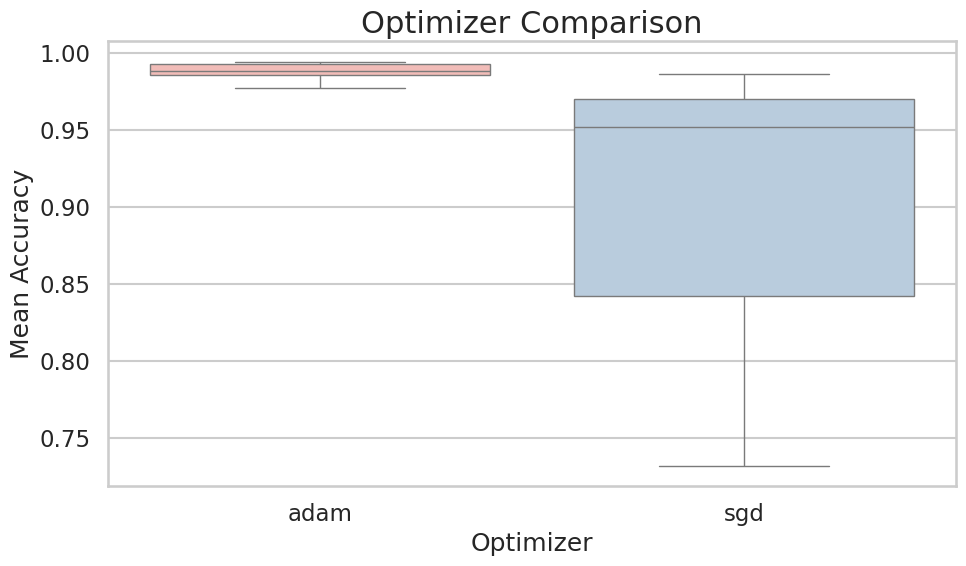

In [ ]:
plt.figure(figsize=(10,6))
sns.boxplot(
    data=df_results,
    x="optimizer",
    y="mean_accuracy",
    palette="Pastel1"
)

plt.title("Optimizer Comparison", fontsize=22)
plt.xlabel("Optimizer", fontsize=18)
plt.ylabel("Mean Accuracy", fontsize=18)

plt.tight_layout()
plt.show()


In [ ]:
best = df_results.iloc[0]
best

,5
lr,0.0001
batch_size,32
optimizer,adam
weight_decay,0.0001
mean_accuracy,0.9942
mean_f1,0.995158


In [ ]:
final_lr = float(best["lr"])
final_bs = int(best["batch_size"])
final_opt = str(best["optimizer"])
final_wd = float(best["weight_decay"])

In [ ]:
# 80/20 final split
skf_final = StratifiedKFold(n_splits=5, shuffle=True, random_state=123)
train_idx, test_idx = next(skf_final.split(np.zeros(len(cached_labels)), cached_labels))

train_dataset = CachedMRIDataset(train_idx, train=True)
test_dataset  = CachedMRIDataset(test_idx, train=False)

train_loader = DataLoader(train_dataset, batch_size=final_bs, shuffle=True, num_workers=2)
test_loader  = DataLoader(test_dataset, batch_size=final_bs, shuffle=False, num_workers=2)

In [ ]:
model = build_model()
optimizer = make_optimizer(model, final_opt, final_lr, final_wd)

for epoch in range(10):
    loss, acc = train_one_epoch(model, optimizer, train_loader)
    print(f"Epoch {epoch+1}: Loss={loss:.4f}, Acc={acc:.4f}")

torch.save(model.state_dict(), "best_mri_model.pth")


Epoch 1: Loss=0.0946, Acc=0.9623
Epoch 2: Loss=0.0279, Acc=0.9912
Epoch 3: Loss=0.0102, Acc=0.9970
Epoch 4: Loss=0.0098, Acc=0.9968
Epoch 5: Loss=0.0073, Acc=0.9972
Epoch 6: Loss=0.0031, Acc=0.9992
Epoch 7: Loss=0.0090, Acc=0.9972
Epoch 8: Loss=0.0022, Acc=0.9995
Epoch 9: Loss=0.0011, Acc=1.0000
Epoch 10: Loss=0.0012, Acc=0.9998


In [ ]:
test_acc, preds_all, labels_all = eval_epoch(model, test_loader)
print("Final Test Accuracy:", test_acc)

Final Test Accuracy: 0.996



Classification Report:

              precision    recall  f1-score   support

     Healthy       0.99      1.00      1.00       400
       Tumor       1.00      0.99      1.00       600

    accuracy                           1.00      1000
   macro avg       1.00      1.00      1.00      1000
weighted avg       1.00      1.00      1.00      1000



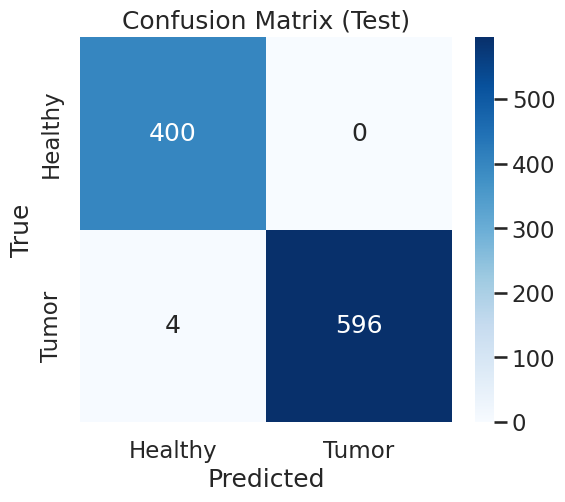

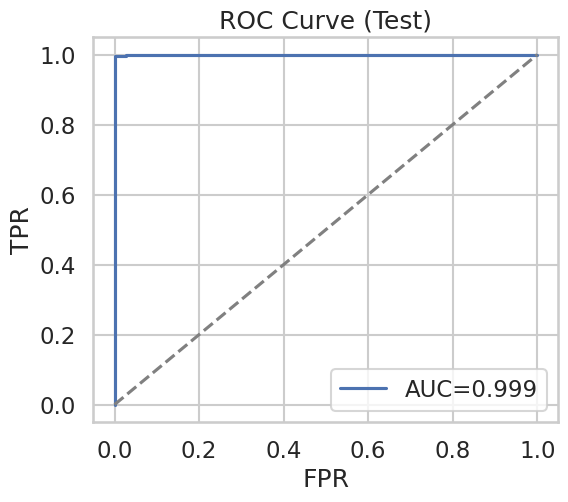

In [ ]:
# Classification Report
print("\nClassification Report:\n")
print(classification_report(labels_all, preds_all, target_names=["Healthy", "Tumor"]))

# Confusion Matrix
cm = confusion_matrix(labels_all, preds_all)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Healthy','Tumor'],
            yticklabels=['Healthy','Tumor'])
plt.title("Confusion Matrix (Test)")
plt.ylabel("True")
plt.xlabel("Predicted")
plt.show()

# ROC + AUC
all_probs = []
with torch.no_grad():
    for imgs, labels in test_loader:
        imgs = imgs.to(device)
        with torch.amp.autocast("cuda"):
            logits = model(imgs)
            probs = logits.softmax(dim=1)[:,1]
        all_probs.extend(probs.cpu().numpy())

fpr, tpr, th = roc_curve(labels_all, all_probs)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f"AUC={roc_auc:.3f}")
plt.plot([0,1],[0,1],'--',color='gray')
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC Curve (Test)")
plt.legend()
plt.show()